In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from ipywidgets import FloatProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
base_dir = currentdir[:currentdir.index('python')] + 'python/'
sys.path.insert(0,base_dir) 
print("Appended base directory", base_dir)

# Import local libraries
from aux.signal.filter import approxDecayConv, approxLPF, windowAvg1D

# Shorthand correlation and spearmann rank
corr = lambda x,y : np.corrcoef(x,y)[0,1]
sprank = lambda x,y : scipy.stats.spearmanr(x,y)[0]

Appended base directory /media/aleksejs/DataHDD/work/codes/snippets-data-analysis/python/


# Analysis of inter-dependance

Most general formulation: Let there be $N$ time-dependent observables, that are observed simultaneously at discrete time points. The future values of each observable depends on its own history, the history of all other observables, and also the history of other, non-observed objects. It is of interest to discover completely the equations of motion of the system, which may be exact or probabilistic. Clearly, any finite amount of data can be explained by an infinite number of equally valid equations of motion, so the exact answer to the problem depends on having a strong underlying model and is to some extend arbitrary and philosophical (e.g. to use or not to use Occam's razor). But data always comes before the model. First, exploratory model-free analysis is necessary to get intuition of which models are possible. In particular, it is useful to determine, which observables are independent, which are weakly or strongly dependent on each other. Formally this is also impossible, since even random finite data could be explained by a very complicated dependence function. Also, in order to make any progress on this problem, the laws governing the interaction of the system with any non-observed systems must be completely known a priori. For example, all observables can in general be explained solely by external input, providing zero information about the interactions within the system. Typically it is assumed that there is no external input, external input is random with a known distribution, or, if we are lucky, external input can be manipulated by the observer. In this exercise, we will start from the other end - assuming a very simple setup first, progressively relaxing assumptions.

At first, let us assume two observables, $X$ and $Y$, produce independent and identically distributed (i.i.d) samples from the joint probability distribution $\rho(x,y)$. For such observables, the question of interest is whether they are independent ($\rho(x,y) = \rho(x)\rho(y)$) or not.


### Correlation and Spearmann rank
Questions of interest are:
* What is a sensible threshold to consider cross-correlation or cross-spearmann rank significant
* How do type-1 and type-2 errors depend on noise and window size
* What is the effect of low-pass-filtering both datasets before computing correlation?

**TODO**: Generate linearly-dependent data with different levels of noise. Test correlation with different levels of noise, different window sizes. Also test pre-low-pass-filtering the data

# Part 1. Effect of non-IID distributions

### 1.1 IID random data

Check the correlation and spearmann rank between two random datasets, depending on dataset size

**Conclusion:**
Correlation of completely random inputs drops roughly as $1 / (2\sqrt{N})$

Correlation fit: 0.59*x^-0.50
Spearmann fit: 0.47*x^-0.48


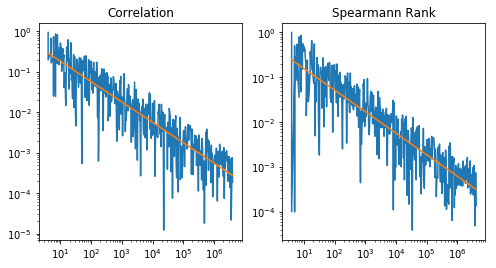

In [2]:
def regfit(x, y, name):
    coeff = np.polyfit(x, y, 1)
    curve = x*coeff[0] + coeff[1]
    print(name + " fit: %.2f*x + %.2f" % (coeff[0], coeff[1]))
    return curve
    
def loglogfit(x, y, name):
    coeff = np.polyfit(np.log(x), np.log(y), 1)
    curve = x**(coeff[0]) * np.exp(coeff[1])
    print(name + " fit: %.2f*x^%.2f" % (np.exp(coeff[1]), coeff[0]))
    return curve

nData = np.array([int(2**(2 + i / 20)) for i in range(400)])
corrData = np.zeros(len(nData))
sprData = np.zeros(len(nData))
for i in range(len(nData)):
    x = np.random.normal(0, 1, nData[i])
    y = np.random.normal(0, 1, nData[i])
    corrData[i] = np.abs(corr(x,y))
    sprData[i] = np.abs(sprank(x,y))
    if sprData[i] == 0:
        sprData[i] = 1.0e-4
    
# Fit line to log-log plot of the resulting data
corrFit = loglogfit(nData, corrData, "Correlation")
sprFit = loglogfit(nData, sprData, "Spearmann")

fig, ax = plt.subplots(ncols = 2, figsize=(8, 4))
ax[0].loglog(nData, corrData)
ax[0].loglog(nData, corrFit)
ax[0].set_title("Correlation")
ax[1].loglog(nData, sprData)
ax[1].loglog(nData, sprFit)
ax[1].set_title("Spearmann Rank");

### 1.2 Wiener process

Check the correlation and spearmann rank between two Wiener processes, depending on dataset size

**Conclusion:**
Wiener processes have non-converging mean and variance. Correlation is not applicable to them, because they strongly violate the i.i.d assumption. It is observed that the absolute value of correlation between two completely random processes fluctuates about 0.5, and can be easily mistaken for genuine dependence

Linear Fit fit: 0.16*x + 940.85
Correlation fit: 0.30*x^0.00
Spearmann fit: 0.25*x^0.02


Text(0.5,1,'Spearmann Rank')

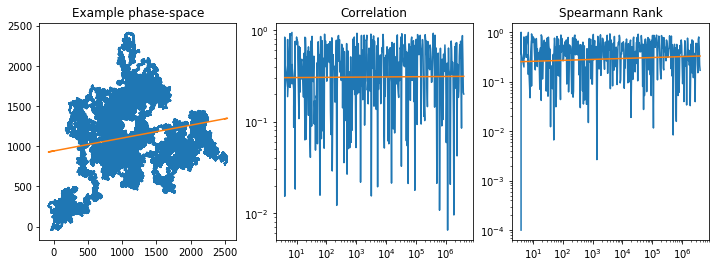

In [3]:
# 2) Test dependence of random correlation on size
nData = np.array([int(2**(2 + i / 20)) for i in range(400)])
corrData = np.zeros(len(nData))
sprData = np.zeros(len(nData))
for i in range(len(nData)):
    x = np.random.normal(0, 1, nData[i])
    y = np.random.normal(0, 1, nData[i])
    
    # Convert random data into Markov chains
    for j in range(1, nData[i]):
        x[j] += x[j-1]
        y[j] += y[j-1]
    
    corrData[i] = np.abs(corr(x,y))
    sprData[i] = np.abs(sprank(x,y))
    if sprData[i] == 0:
        sprData[i] = 1.0e-4
    
# Fit line to log-log plot of the resulting data
linFit = regfit(x, y, "Linear Fit")
corrFit = loglogfit(nData, corrData, "Correlation")
sprFit = loglogfit(nData, sprData, "Spearmann")

fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
ax[0].plot(x, y)
ax[0].plot(x, linFit)
ax[0].set_title("Example phase-space")
ax[1].loglog(nData, corrData)
ax[1].loglog(nData, corrFit)
ax[1].set_title("Correlation")
ax[2].loglog(nData, sprData)
ax[2].loglog(nData, sprFit)
ax[2].set_title("Spearmann Rank")

### 1.3 Low-pass filtered random data

Check the correlation and spearmann rank between two processes with exponentially decaying response (lag), depending on dataset size

**Conclusion:**
Laggy process does converge, but requires orders of magnitude more data, depending on the lag

FloatProgress(value=0.0, max=200.0)

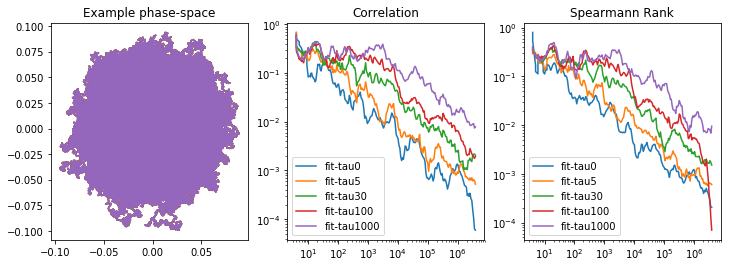

In [20]:
DT = 1
nStep = 200
nData = np.array([int(2**(2 + i/10)) for i in range(nStep)])
tau = [0, 5, 30, 100, 1000]
nTau = len(tau)

#######################################
# Compute correlations for decay data
#######################################

corrData = np.zeros((nTau, nStep))
sprData = np.zeros((nTau, nStep))

progBar = FloatProgress(min=0, max=nStep) # instantiate the bar
display(progBar) # display the bar

for iData in range(len(nData)):
#     print("doing data size", nData[iData])
    x = np.random.normal(0, 1, nData[iData])
    y = np.random.normal(0, 1, nData[iData])

    for iTau in range(nTau):
        # Convolve data with laggy kernel
        xLPF = approxDecayConv(x, tau[iTau], DT)
        yLPF = approxDecayConv(y, tau[iTau], DT)

        corrData[iTau][iData] = np.abs(corr(xLPF, yLPF))
        sprData[iTau][iData] = np.abs(sprank(xLPF, yLPF))
        if sprData[iTau][iData] == 0:
            sprData[iTau][iData] = 1.0e-5
    
    # Increase progressbar counter
    progBar.value += 1
    
#######################################
# Fit and plot
#######################################
    
# Fit line to log-log plot of the resulting data
corrFit = np.zeros((nTau, nStep))
sprFit = np.zeros((nTau, nStep))
for iTau in range(nTau):
    corrFit[iTau] = np.exp(windowAvg1D(np.log(corrData[iTau]), 10)) #np.exp(smoothWindow(np.log(corrData[iTau]), 40))
    sprFit[iTau] = np.exp(windowAvg1D(np.log(sprData[iTau]), 10)) #np.exp(smoothWindow(np.log(sprData[iTau]), 40))

fig, ax = plt.subplots(ncols = 3, figsize=(12, 4))
ax[0].set_title("Example phase-space")
ax[1].set_title("Correlation")
ax[2].set_title("Spearmann Rank")
ax[0].plot(xLPF, yLPF)
for iTau in range(nTau):
    #ax[1].loglog(nData, corrData[iTau], label = "data-tau"+str(tau[iTau]))
    ax[1].loglog(nData, corrFit[iTau], label = "fit-tau"+str(tau[iTau]))
    #ax[2].loglog(nData, sprData[iTau], label = "data-tau"+str(tau[iTau]))
    ax[2].loglog(nData, sprFit[iTau], label = "fit-tau"+str(tau[iTau]))
ax[1].legend()
ax[2].legend();

# Part 2. Effect of cross-correlation of Type-1 error

**[TODO]**
* Construct cross-correlation for random-lpf data with a timescale of $\pm 2 \tau$
* Bin the data using varying bin sizes, see how that affects cross-correlation

# Part 3. Typical responses for real data

**[TODO]**
* Generate a bunch of real oscillators with different frequencies
* add velocity and sampling noise to each. 
* Perform correlation between all positions and velocities, check that it can pick up x-v pairs
* Progressively apply decay and use cross-correlation, see if it still works
* Think of a process with faster and slower timescales, such that even with LPF there would still be something left